# Statistiques descriptives

Ici nous analyserons de façon globale les données textuelles que nous avons, en l'occurrence un corpus de X textes lemmatisés avec pour chaque lemme sa **fréquence** et son **type** associés.

Pour ce faire nous aurons besoin de :  
1.  `numpy` et `pandas` pour les opérations sur les données 
2.  `matplotlib.pyplot` pour la création de graphiques

In [2]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Nous récupérons les **titres** des textes de `'Data/base_csv_final.csv'` et les **lemmes** (et leur fréquences et leurs types) de `'Data/info.parquet'`.

In [3]:
#Collecting data
texts=pd.read_csv('Data/base_csv_final.csv')
d_titles=texts['Title'].to_dict()
data=pd.read_parquet('Data/info.parquet', engine='pyarrow')

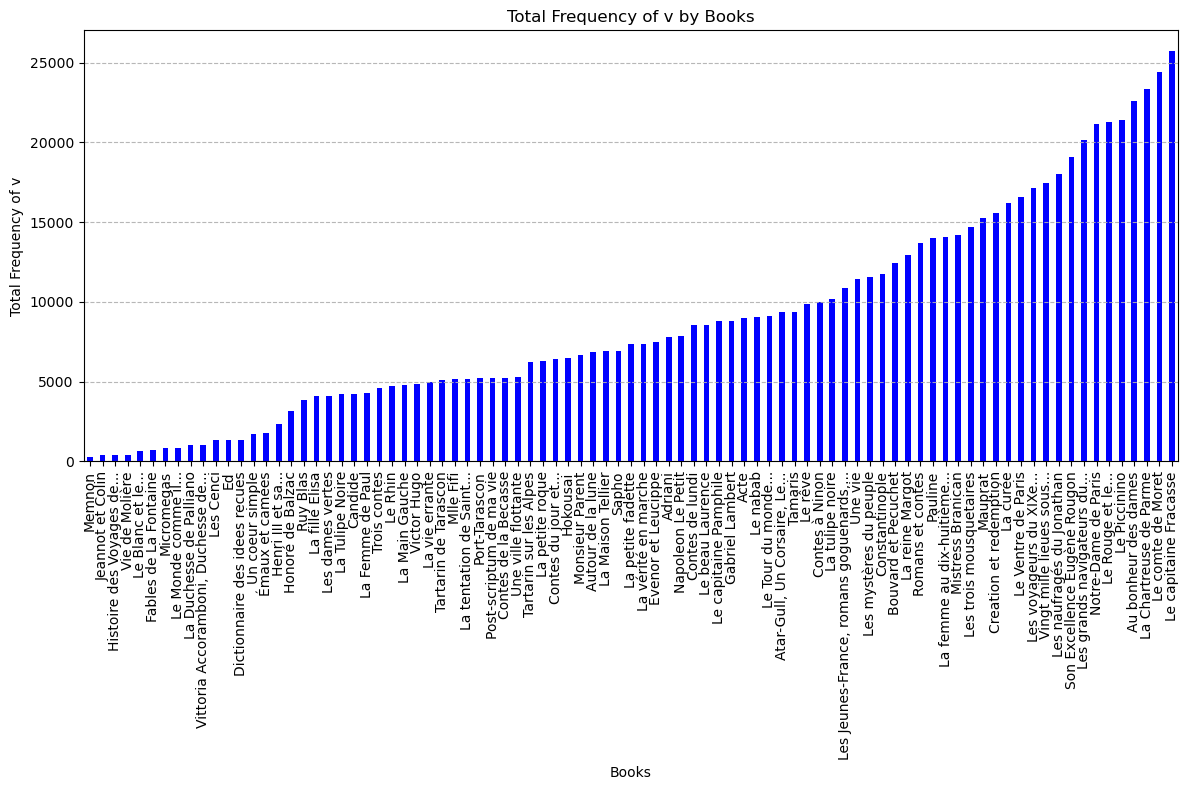

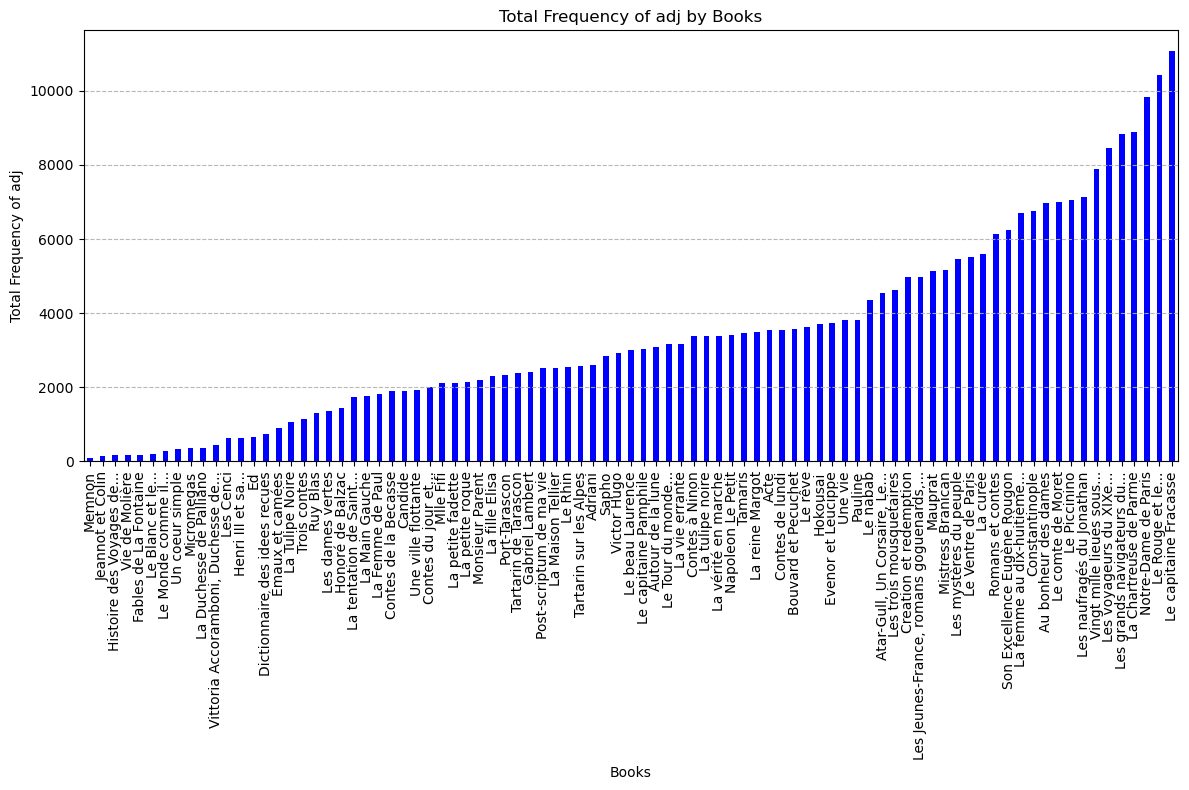

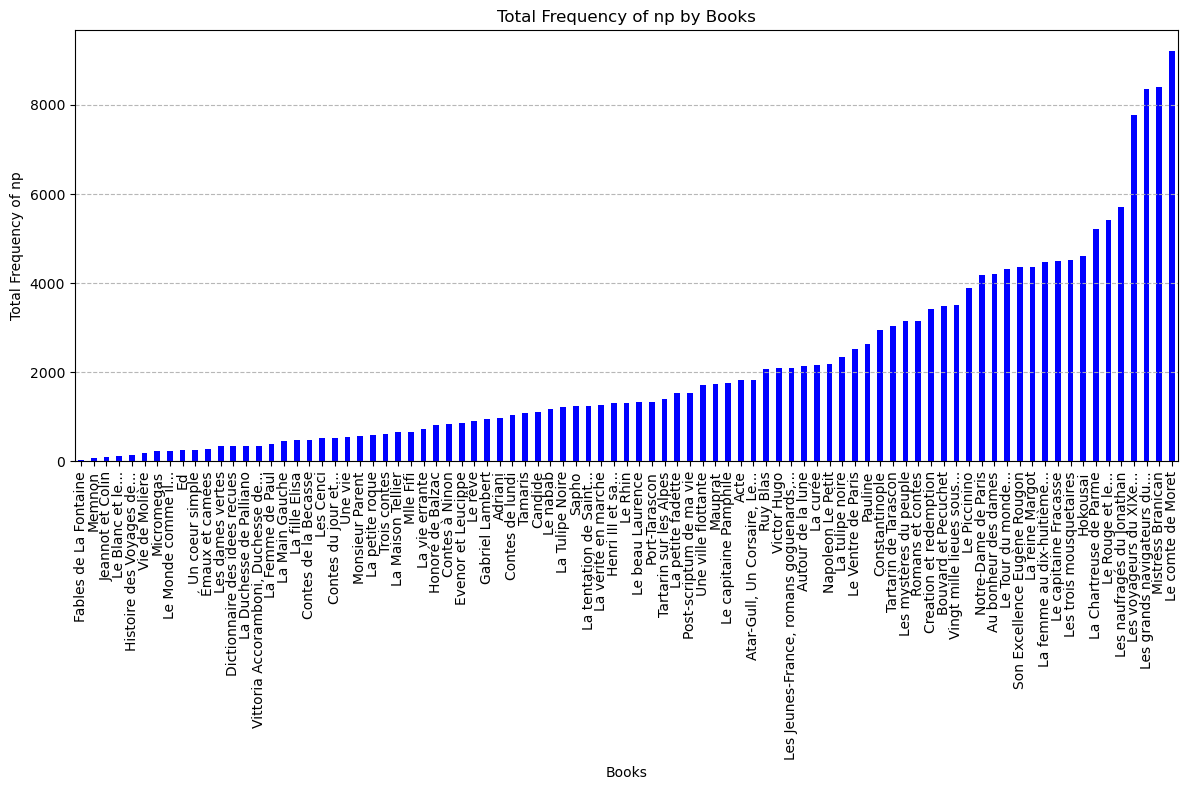

In [5]:
for w_type in ['v','adj','np'] :

    #Tri de data en fonction du type
    df_sorted = data[data['Type'] == w_type]

    #Somme des fréquences des mots de ce type par livre
    df_sum= df_sorted.groupby('Id')['Freq'].sum()
    d_freq = {
        #Ne retient que les 4 premiers mots de d_titles et ajoute '...' si le titre est plus long
        ' '.join(d_titles.get(book_id, book_id).split()[:4]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 4 else ''): freq
        for book_id, freq in df_sum.items()
    }
    #Tri pour avoir des valeurs croissantes
    d_freq_sorted = dict(sorted(d_freq.items(), key=lambda item: item[1]))
    #Taille du graph
    plt.figure(figsize=(12, 8))
    #Répartition des positions pour l'axe des abscisses
    x_positions = np.arange(len(d_freq_sorted))*2
    #Tracé des barres
    plt.bar(x_positions, list(d_freq_sorted.values()), color='blue', width=0.9)
    #Titre et labels des axes
    plt.title(f'Total Frequency of {w_type} by Books')
    plt.xlabel('Books')
    plt.ylabel(f'Total Frequency of {w_type}')
    #Ajout d'une grille honrizontale
    plt.grid(True, axis='y', linestyle='--', alpha=0.9)
    #Limites de l'axe des abscisses
    plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
    #Paramètres des abscisses 
    plt.xticks(x_positions, list(d_freq_sorted.keys()), rotation=90, ha='center', fontsize=10) 
    #Affichage (tight_layout pour un rendu plus propre)
    plt.tight_layout()
    plt.show()


Ce programme sert à afficher le **nombre total de mots** dans chaque livre. Sans rentrer dans les détails :
1. Il récupère les fréquences de chaque lemmes dans la colonne `"Freq"`(en tenant compte du livre auquel ils appartiennt grâce à la colonne `"Id"`)
2. Il ne garde des titres que les 4 premiers mots pour des raisons d'affichage et trie les données dans l'ordre croissant
3. Les dernières lignes sont des commandes d'affichages propre à `matplotlib.pyplot` qui seront peu ou prou les mêmes pour chaque graphique


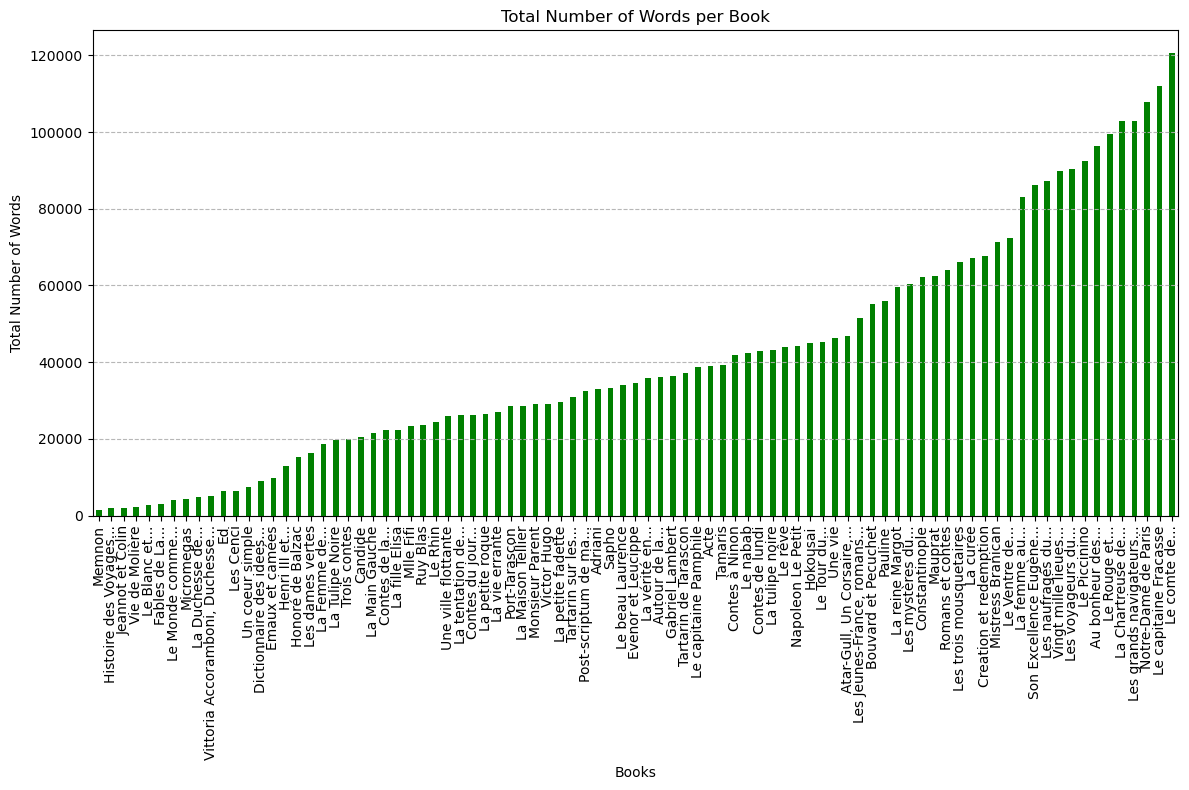

In [11]:
#Nombre total de mots par livre
w_total = data.groupby('Id')['Freq'].sum()

#Titre avec seulement les 4 premiers mots et nombre total de mots
d_total = {
    ' '.join(d_titles.get(book_id, book_id).split()[:3]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 3 else ''): count
    for book_id, count in w_total.items()
}

#Tri par valeurs croissantes
d_total_sorted = dict(sorted(d_total.items(), key=lambda item: item[1]))

# Positions for the x-axis
x_positions = np.arange(len(d_total_sorted)) * 2

#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(d_total_sorted))*2
#Tracé des barres
plt.bar(x_positions, list(d_total_sorted.values()), color='green', width=0.9)
#Titre et labels des axes
plt.title('Total Number of Words per Book')
plt.xlabel('Books')
plt.ylabel('Total Number of Words')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, list(d_total_sorted.keys()), rotation=90, ha='center', fontsize=10)
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()

Nous avons ainsi une meilleure idée de la distribution des tailles des livres. *Memnon* est par exemple le plus court, Le comte de... (*Le comte de Moret*), le plus long.

Maintenant, regardons la distribution de la diversité des lemmes. Le programme est sensiblement le même qu'au-dessus, à cela près qu'il s'intéresse aux valeurs uniques de la colonne `Word` (Lemmes) plutôt que `Freq`.

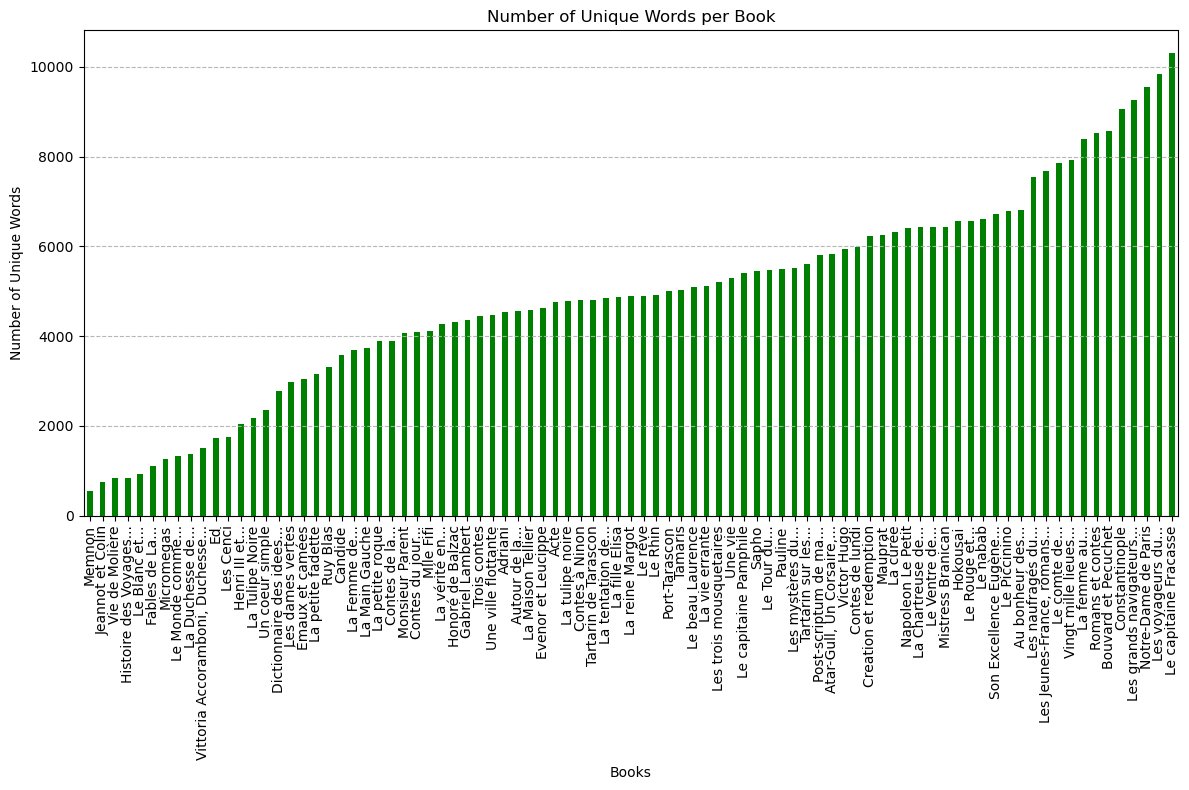

In [9]:
import matplotlib.pyplot as plt
import numpy as np

#Nombre de mots différents par livre
w_unique = data.groupby('Id')['Word'].nunique()

#Titre avec seulement les 4 premiers mots et nombre de mots unique
d_unique = {
    ' '.join(d_titles.get(book_id, book_id).split()[:3]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 3 else ''): count
    for book_id, count in w_unique.items()
}

#Tri par valeurs croissantes
d_unique_sorted = dict(sorted(d_unique.items(), key=lambda item: item[1]))

# Positions for the x-axis
x_positions = np.arange(len(d_unique_sorted)) * 2

#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(d_freq_sorted))*2
#Tracé des barres
plt.bar(x_positions, list(d_unique_sorted.values()), color='green', width=0.9)
#Titre et labels des axes
plt.title('Number of Unique Words per Book')
plt.xlabel('Books')
plt.ylabel('Number of Unique Words')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, list(d_unique_sorted.keys()), rotation=90, ha='center', fontsize=10)
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()


*Le Memnon* reste le livre avec le plus petit nombres de lemmes et le bas de la distribution change peu du fait de questions de proportions. En revanche, le haut de la distribution change beaucoup. Par exemple, *Le capitaine Fracasse* a le plus grand nombre de lemmes différents et à l'inverse, malgré sa grande taille, *Le comte de Moret* se retrouve en 10ème position.

Pour véritablement avoir une idée de la diversité de chaque livre, on construit un **coefficient de diversité**. Il s'agit tout simplement du rapport entre le nombres de lemmes différents et le nombre total de lemmes. Ainsi, plus le coefficient est proche de 1, plus le vocabulaire employé est riche. Le fonctionnement du code combine les deux approches ci-dessus.

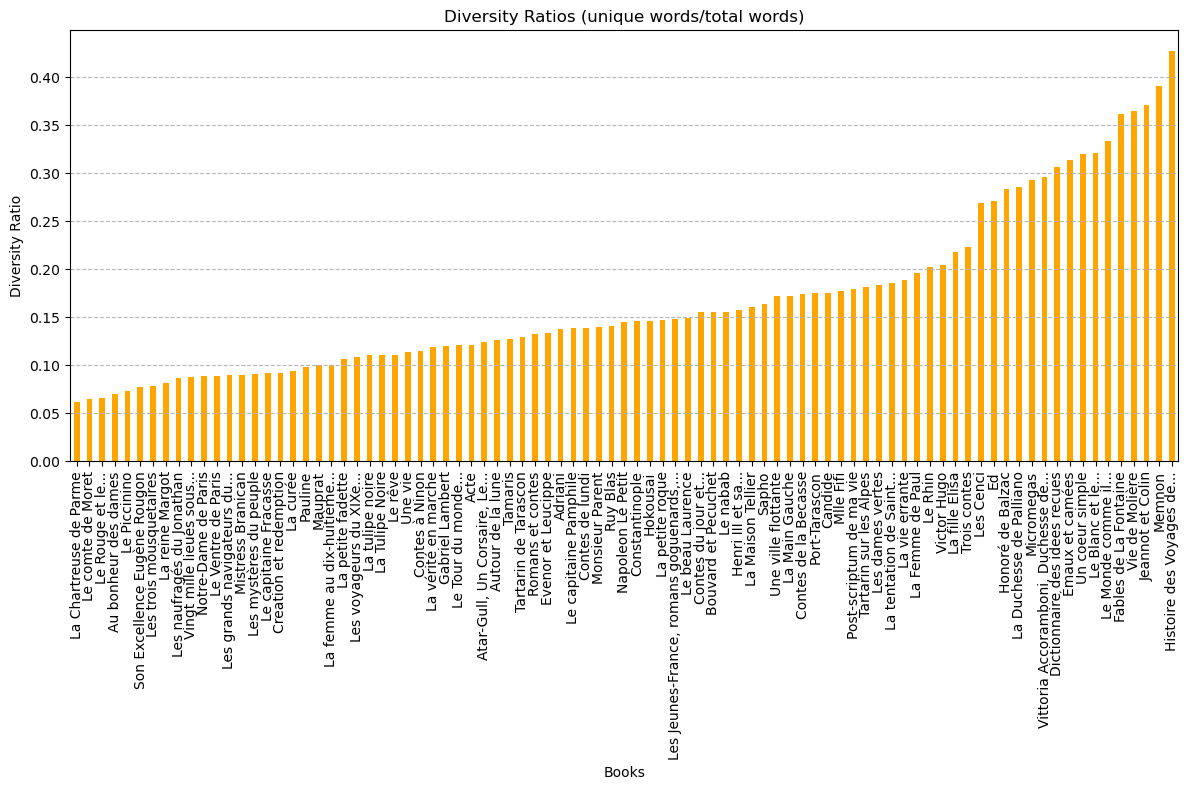

In [40]:
import numpy as np
import matplotlib.pyplot as plt

#Nombre de mots total par livre et nombre de mots différent
w_total= data.groupby('Id')['Freq'].sum()  
w_unique = data.groupby('Id')['Word'].nunique() 

# Coefficient de diversité (nombre de mots différents/nombre de mots total)
diversity_ratio = (w_unique / w_total).sort_values()


#Ne retient que les 4 premiers mots de d_titles et ajoute '...' si le titre est plus long
l_books =  [' '.join(d_titles.get(book_id, book_id).split()[:4]) + ('...' if len(d_titles.get(book_id, book_id).split()) > 4 else '') for book_id in diversity_ratio.index]


#Taille du graph
plt.figure(figsize=(12, 8))
#Répartition des positions pour l'axe des abscisses
x_positions = np.arange(len(diversity_ratio)) * 2
#Tracé des barres
plt.bar(x_positions, diversity_ratio, color='orange', width=0.9)
#Titre et labels des axes
plt.title('Diversity Ratios (unique words/total words)')
plt.xlabel('Books')
plt.ylabel('Diversity Ratio')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Limites de l'axe des abscisses
plt.xlim(min(x_positions) - 1, max(x_positions) + 1)
#Paramètres des abscisses 
plt.xticks(x_positions, l_books, rotation=90, ha='center', fontsize=10)  # Rotate x-axis labels for better readability
#Affichage (tight_layout pour un rendu plus propre)
plt.tight_layout()
plt.show()

On observe, sans surprise, que les plus petits livres ont une diversité bien plus grande. Par exemple, la nouvelle *Un coeur simple* est la 8ème la plus riche en termes de vocabulaire et l'énorme roman qu'est *La Chartreuse de Parme* en dernière position.   
Notons qu'*Un coeur simple* est au-dessus de *Trois contes* de 8 places, alors même que cette nouvelle fait partie des trois contes. Même si les deux autres contes peuvent influer sur la diversité du vocabulaire, cela nous conforte dans l'idée que la taille du livre est une variable très importante dans l'analyse de nos données.  
Cependant, si l'on regarde le bas de la distribution, on retrouve certains des résultats au-dessus (par exemple la place cohérente de *Le capitaine Fracasse*, ayant beaucoup de lemmes et très diversifiés, par rapport à *Le comte de Moret*).
De même, *Ruy Blas* a beau être une pièce de théâtre, son faible nombre de lemmes différents (voir au-dessus) fait que son coefficient de diversité est proche de la médiane. Ainsi, même un texte plus court peut avoir un coefficient moins élevé, laissant à penser que l'indicateur est biaisé mais tout de même pertinent.

Le programme suivant compte le nombre moyen de chaque type de mots, utilisé dans chaque livre. Tout d'abord, il agrège les fréquences par type et par livre puis il en calcule la moyenne grâce à `.mean()`.

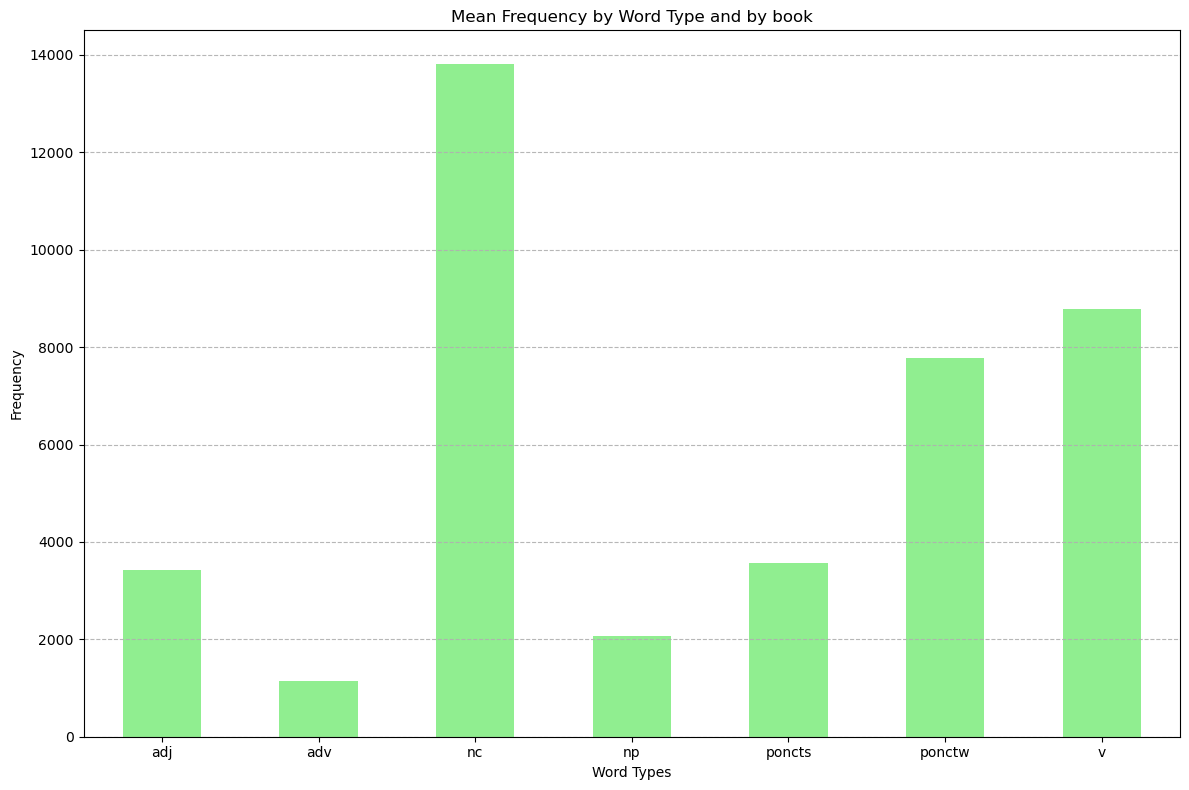

In [42]:
#Somme des fréquences par livre et type
df_stats = data.groupby(['Id', 'Type'])['Freq'].sum().reset_index()
#Récupération des moyenns par type
df_stats = df_stats.groupby('Type')['Freq'].mean()

#Liste des principeaux types de mots
l_included = ['nc', 'v', 'adj', 'np', 'adv', 'ponctw','poncts']

#Filtrage pour ne garder que les types voulus
df_filtered = df_stats[df_stats.index.isin(l_included)]

# Step 3: Plot the results
df_filtered.plot(kind='bar', figsize=(12, 8), color=['lightgreen'])

#Titre et labels des axes
plt.title('Mean Frequency by Word Type and by book')
plt.xlabel('Word Types')
plt.ylabel('Frequency')
#Ajout d'une grille honrizontale
plt.grid(True, axis='y', linestyle='--', alpha=0.9)
#Abscisses mises à l'horizontal
plt.xticks(rotation=0)
#Affichage
plt.tight_layout()
plt.show()

La distribution des types est très cohérentes. Les noms communs, les marques de ponctuations (`"poncts"` et `"ponctw"`) et les verbes sont omniprésents. Les adjectifs semblent légèrement rares par rapport à ce à quoi l'on pourrait s'attendre. en revanche, les adverbes sont, de façon très logique peu présents.

Regardons maintenant la distribution des livres par thème. Le programme fonctionne comme suit : 
1. Il réorganise la colonne `"Themes"` en dupliquant chaque ligne contenant plusieurs thèmes (pour n'avoir plus qu'un thème par ligne)
2. Il recense le nombre de livres pour chaque thème
3. Affichage de l'histogramme grâce à `matplotlib.pyplot`

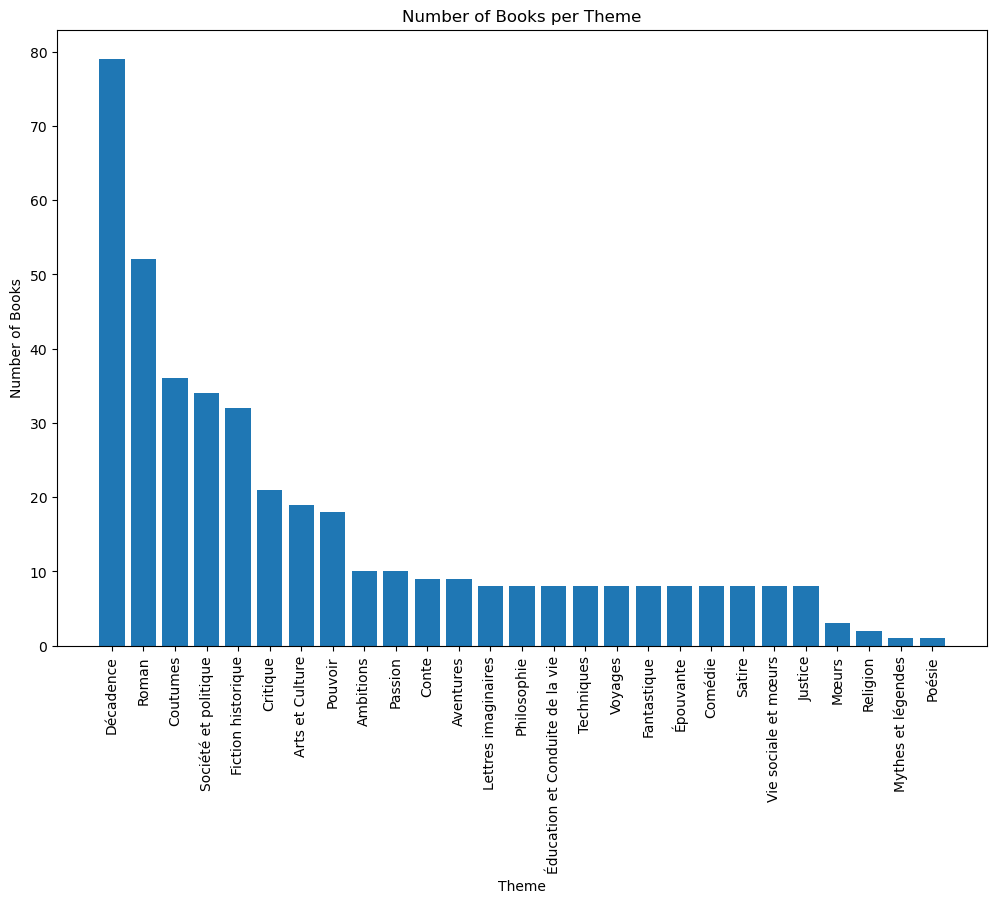

In [13]:
#Séparation des thèmes en listes si les thèmes sont sous forme d'un unique string
texts['Themes'] = texts['Themes'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

#Création de lignes spullémentaires pour qu'il n'y ait plus que un thème par ligne
texts_exploded = texts.explode("Themes")

#Nombre de livres par thème dans un dataframe
df_counts = texts_exploded['Themes'].value_counts().reset_index()
df_counts.columns = ['Theme', 'Number of Books']


#Taille graph
plt.figure(figsize=(12, 8))
#Tracé des barres
plt.bar(df_counts['Theme'], df_counts['Number of Books'])
#Titre et labels des axes
plt.xlabel('Theme')
plt.ylabel('Number of Books')
plt.title('Number of Books per Theme')
#Abscisses à l'horizontal
plt.xticks(rotation=90, fontsize=10)
#Affichage
plt.show()

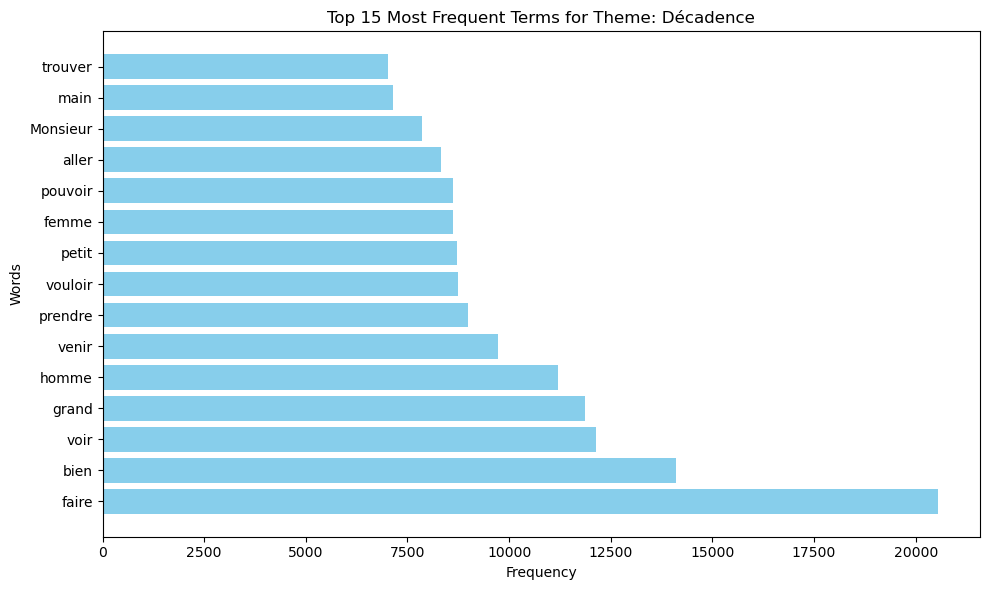

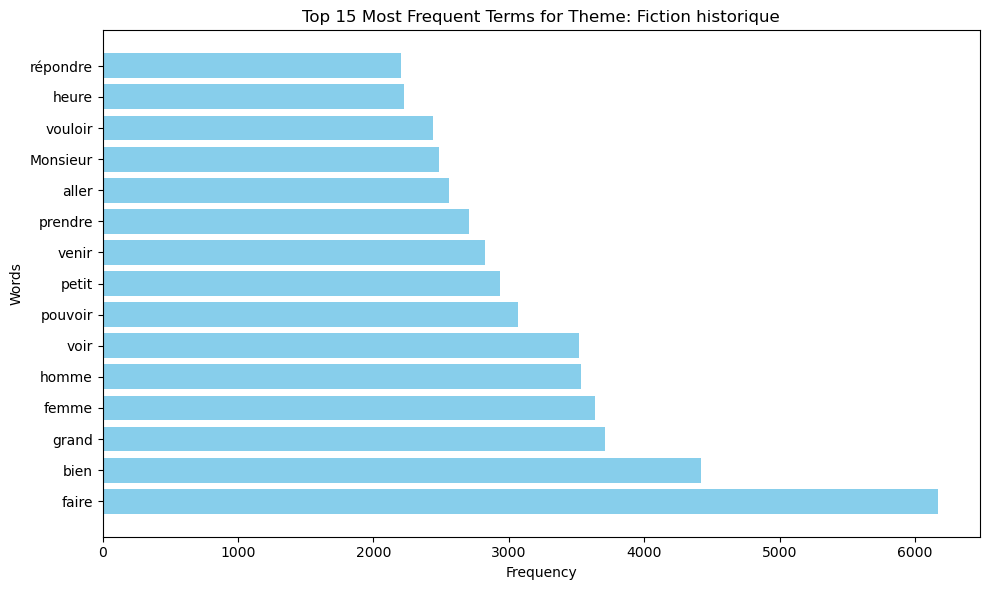

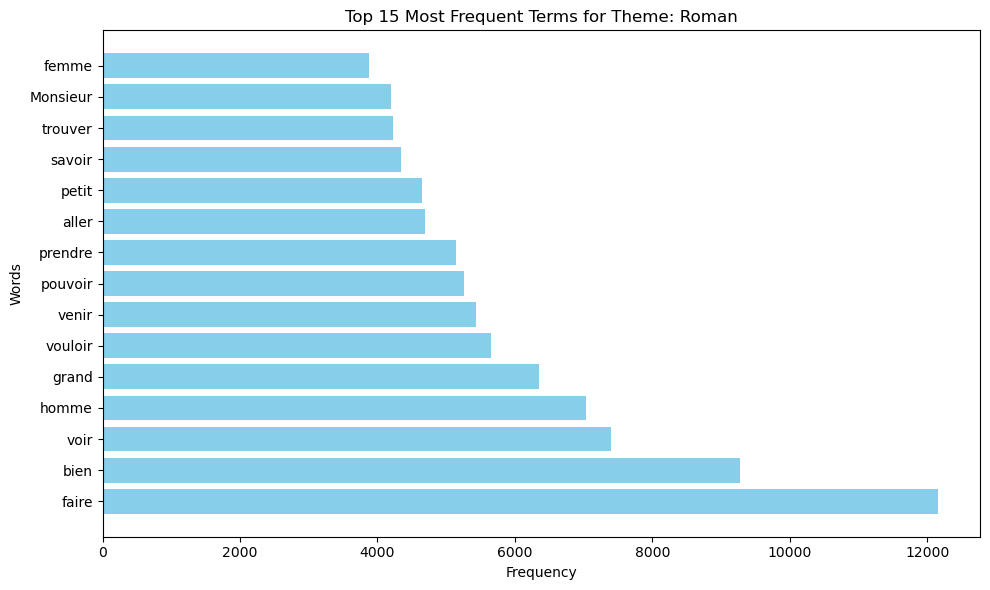

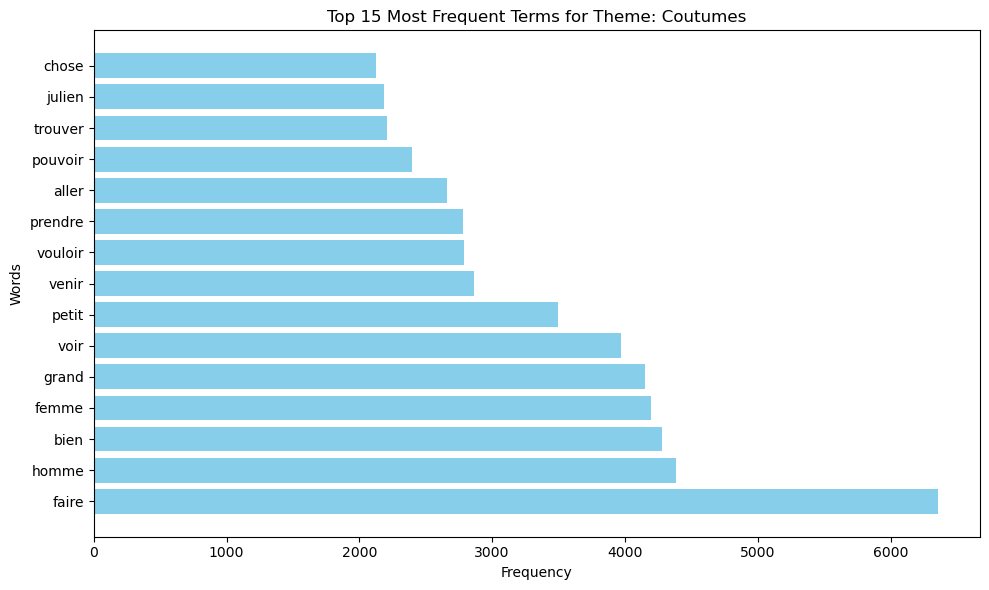

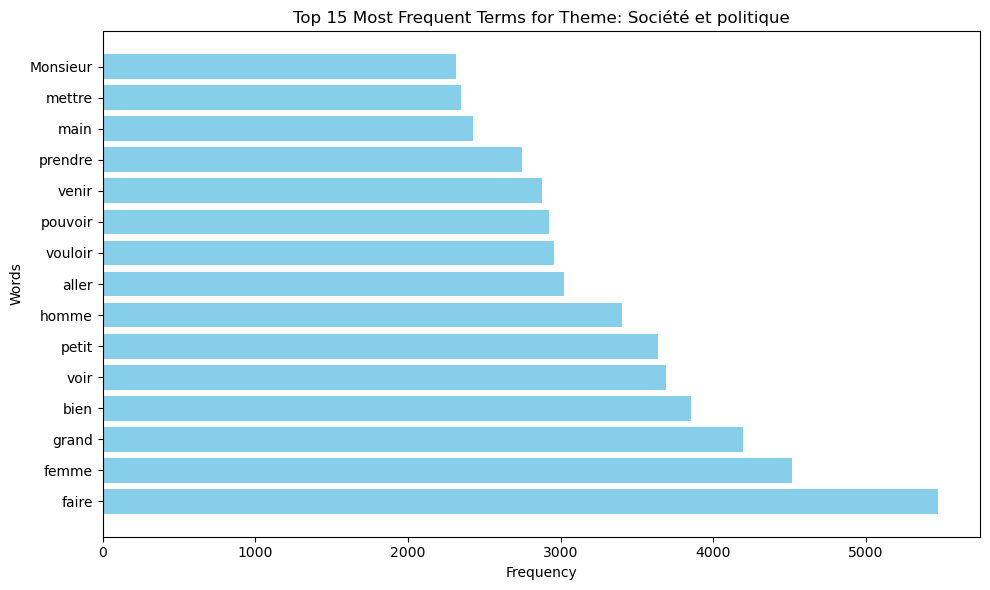

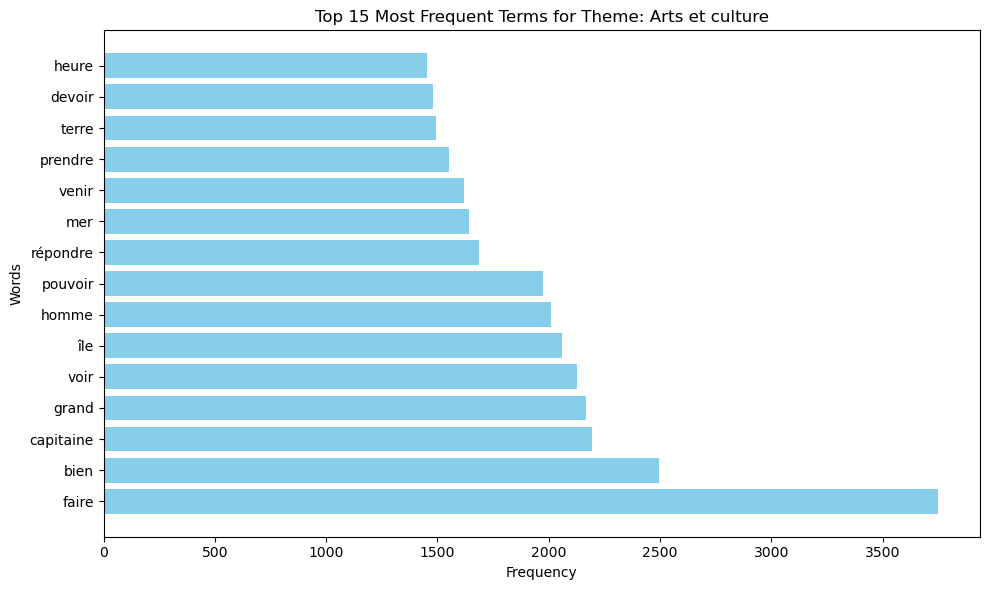

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

#Création d'un dictionaire (avec des valeurs par défaut il y a des valeurs manquantes)
d_freq = defaultdict(lambda: defaultdict(int))
#Types de mots retenus
include_types = ['nc', 'v', 'adj', 'np', 'adv']

total_word_freq = defaultdict(int)
word_theme_count = defaultdict(int)

for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes']
    book_id = idx
    book_df = data[data['Id'] == book_id]
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for word, freq, word_type in zip(words, frequencies, types):
        if word_type in include_types:
            total_word_freq[word] += freq
            for theme in themes:
                word_theme_count[word] += 1

top_20_words = {word for word, freq in sorted(total_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]}
exclude_words = {word for word, count in word_theme_count.items() if count > 3}

for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes']
    book_id = idx
    book_df = data[data['Id'] == book_id]
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for theme in themes:
        for word, freq, word_type in zip(words, frequencies, types):
            if word_type in include_types and word not in top_20_words and word not in exclude_words:
                freq = float(freq)
                d_freq[theme.strip().lower()][word] += freq

themes_to_plot = ["Décadence", "Roman", "Coutumes","Société et politique", "Fiction historique","Arts et culture"]

for theme, word_freqs in d_freq.items():
    if theme in [t.lower() for t in themes_to_plot]:
        sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15]
        words, freqs = zip(*sorted_words)
        plt.figure(figsize=(10, 6))
        plt.barh(words, freqs, color='skyblue')
        plt.title(f"Top 15 Most Frequent Terms for Theme: {theme.capitalize()}")
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.tight_layout()
        plt.show()


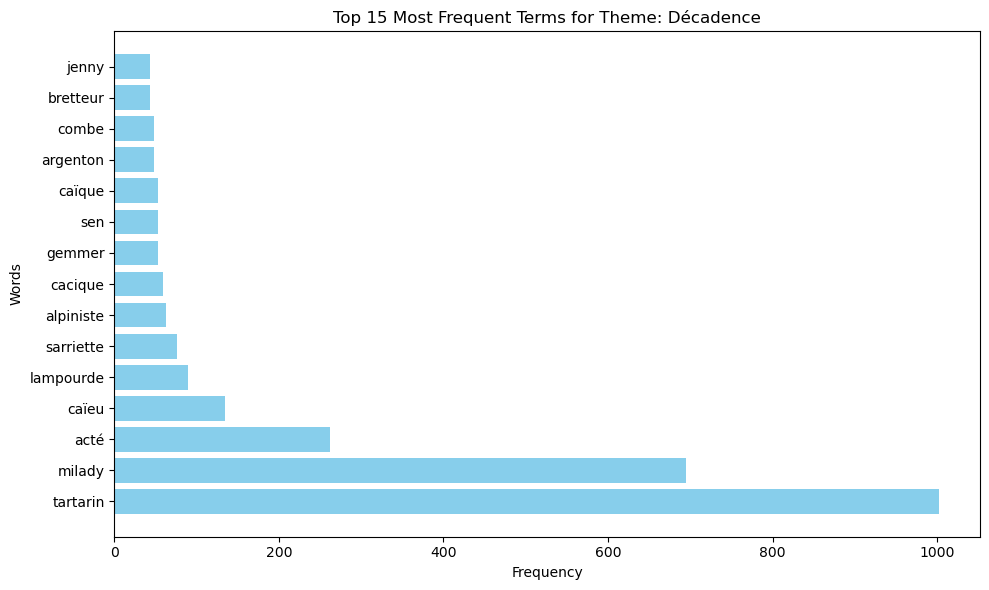

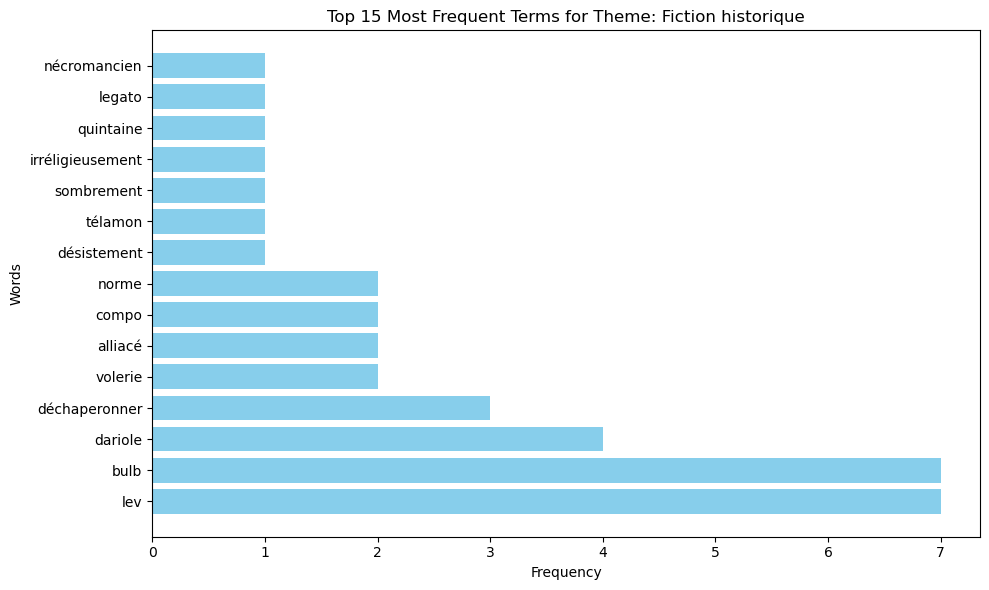

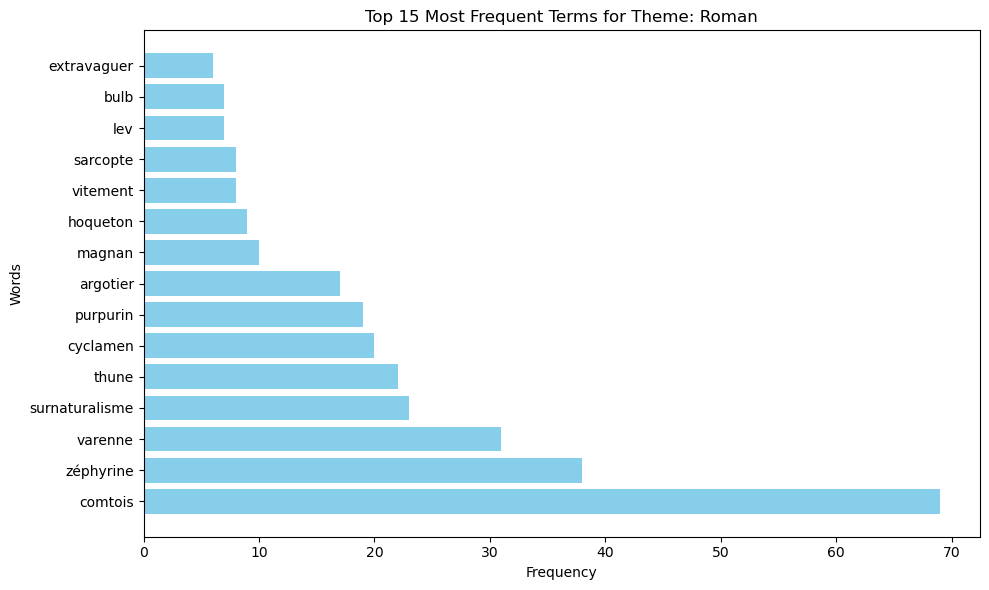

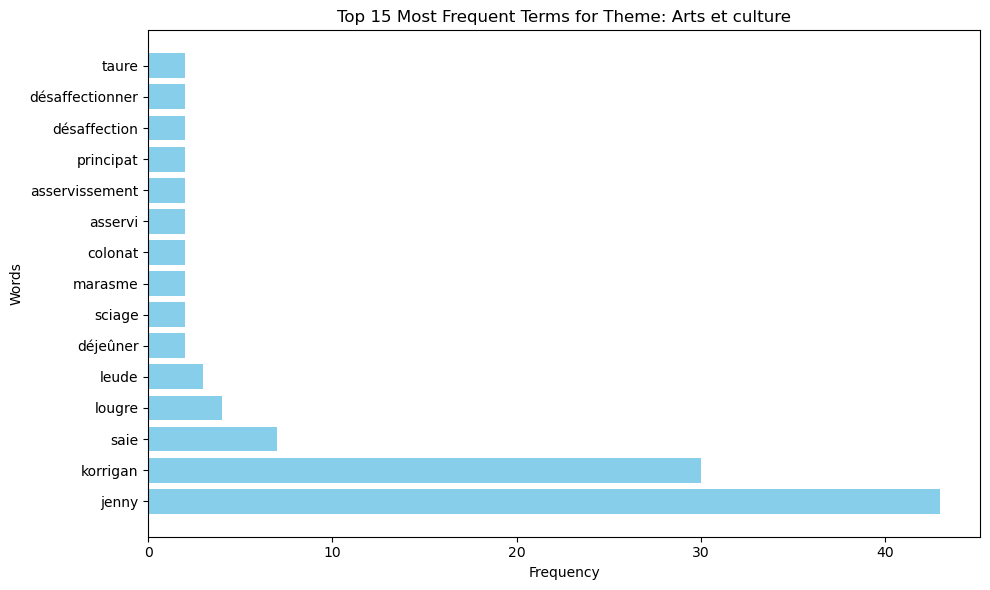

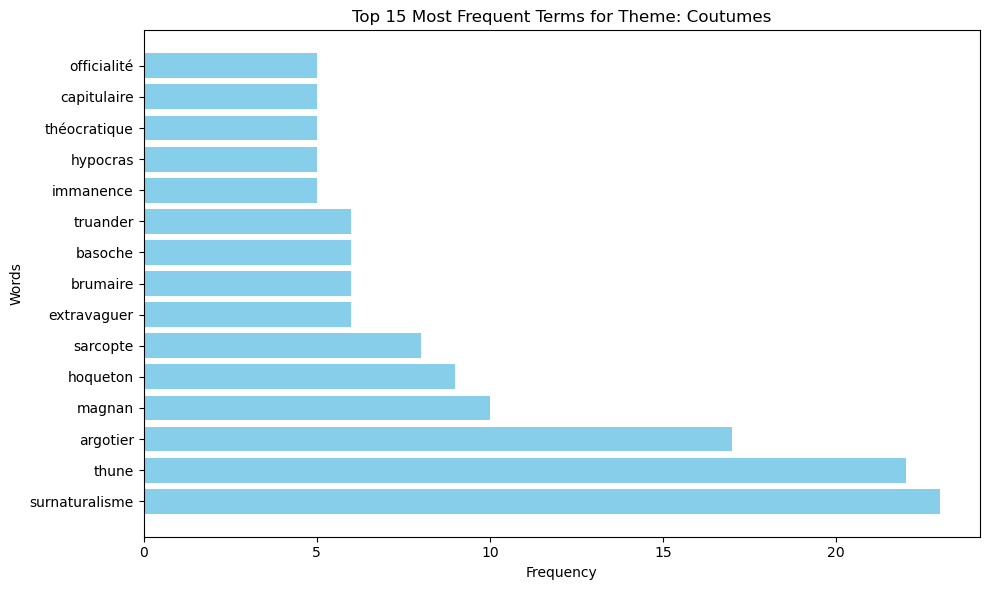

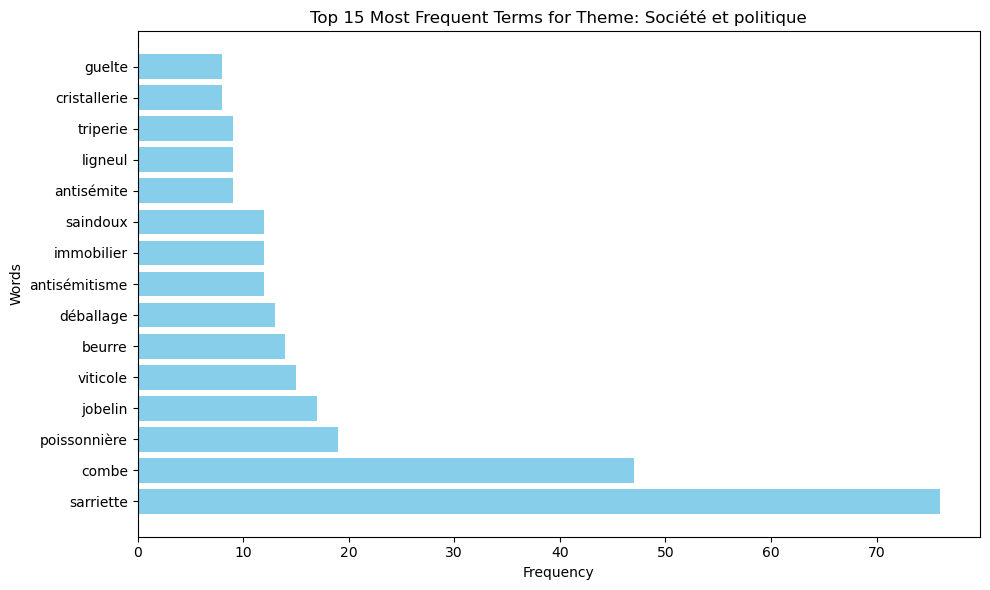

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Step 1: Create a dictionary to store word frequencies for each theme
theme_word_freq = defaultdict(lambda: defaultdict(int))

# Set the types of words you want to exclude (e.g., 'punctuation' and 'stopword')
exclude_types = ["epsilon", "ponctw", "poncts", "parento", "parentf", "np"]

# Step 2: Calculate the total word frequencies across all books to identify the top 20 most frequent words
total_word_freq = defaultdict(int)

# Create a dictionary to track in how many themes each word appears
word_theme_count = defaultdict(int)

# Step 3: Loop through each book in 'texts' and update the total word frequencies and theme counts
for idx, row in texts.iterrows():
    # Get the book title and themes for the current row
    book_title = row['Title']
    themes = row['Themes'].split(",")
    
    # Get the corresponding book Id from the current row (idx)
    book_id = idx  # 'idx' is the row number in texts, which corresponds to the 'Id' in data
    
    # Filter the 'data' dataframe using the book Id
    book_df = data[data['Id'] == book_id]
    
    # Get the words, frequencies, and types from the respective columns
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    # Update total word frequency for all words across all books
    for word, freq, word_type in zip(words, frequencies, types):
        if word_type not in exclude_types:  # Only consider valid types
            total_word_freq[word] += freq
            
            # Count in how many themes the word appears
            for theme in themes:
                word_theme_count[word] += 1

# Step 4: Get the top 20 most frequent words across all books
top_20_words = {word for word, freq in sorted(total_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]}

# Step 5: Identify words that appear in strictly more than 2 themes
exclude_words = {word for word, count in word_theme_count.items() if count > 3}

# Step 6: Calculate word frequencies for each theme across all books, excluding top 20 frequent words and words in more than 2 themes
for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes'].split(",")
    
    # Get the corresponding book Id from the current row (idx)
    book_id = idx  # 'idx' is the row number in texts, which corresponds to the 'Id' in data
    
    # Filter the 'data' dataframe using the book Id
    book_df = data[data['Id'] == book_id]
    
    # Get the words, frequencies, and types from the respective columns
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    # For each theme, add the word frequencies to the theme's frequency dictionary
    for theme in themes:
        for word, freq, word_type in zip(words, frequencies, types):  # Map words, frequencies, and types
            if word_type not in exclude_types and word not in top_20_words and word not in exclude_words:  # Exclude top 20 and words in > 2 themes
                # Directly convert freq to float (removing the try-except block)
                freq = float(freq)  # Convert freq to float if it's not already a number
                theme_word_freq[theme.strip().lower()][word] += freq  # Strip and convert theme to lowercase to avoid duplication

# Step 8: Define the list of themes you want to plot (ensure they match exactly)
themes_to_plot = ["Décadence", "Roman", "Coutumes","Société et politique", "Fiction historique","Arts et culture"] # Replace with your actual theme names, make sure they're in lowercase and match exactly

# Step 9: Plot the 15 most frequent terms for the specified themes only
for theme, word_freqs in theme_word_freq.items():
    # Check if the theme is in the list of themes to plot
    if theme in [t.lower() for t in themes_to_plot]:  # Ensure case-insensitive matching
        # Sort words by frequency (descending)
        sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15]
        
        # Prepare data for plotting
        words, freqs = zip(*sorted_words)
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.barh(words, freqs, color='skyblue')
        plt.title(f"Top 15 Most Frequent Terms for Theme: {theme.capitalize()}")
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.tight_layout()
        plt.show()


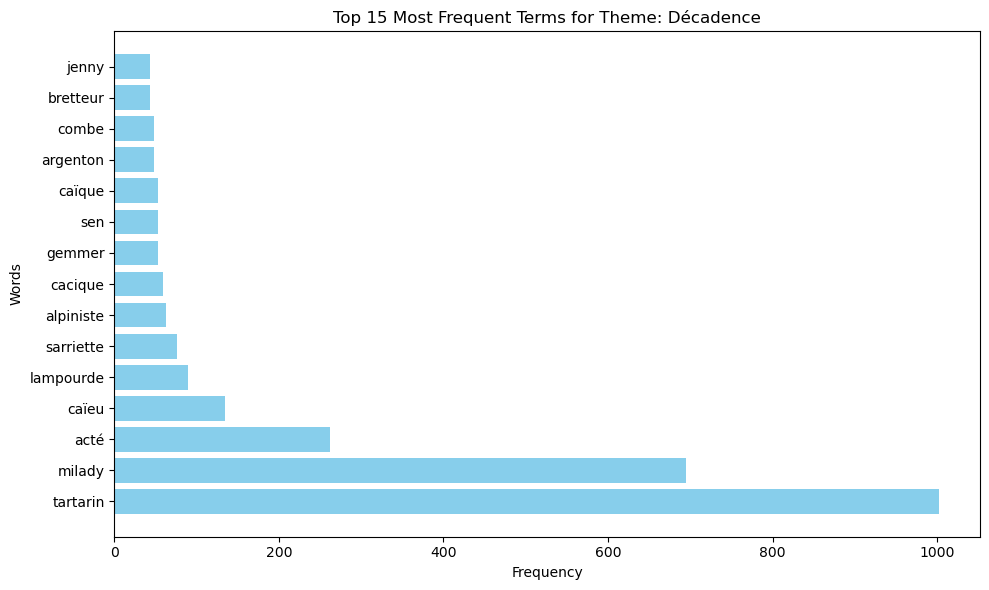

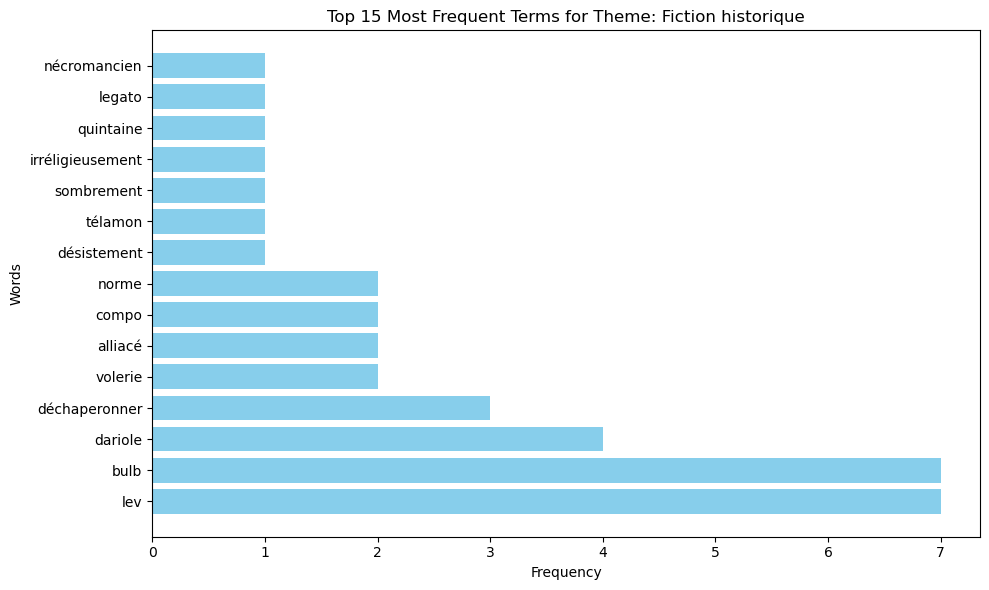

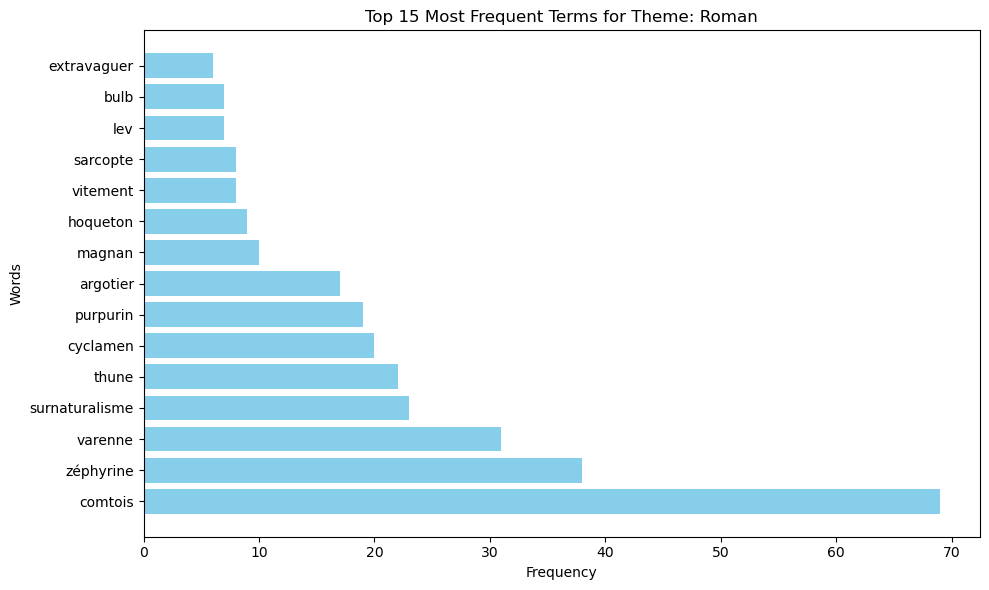

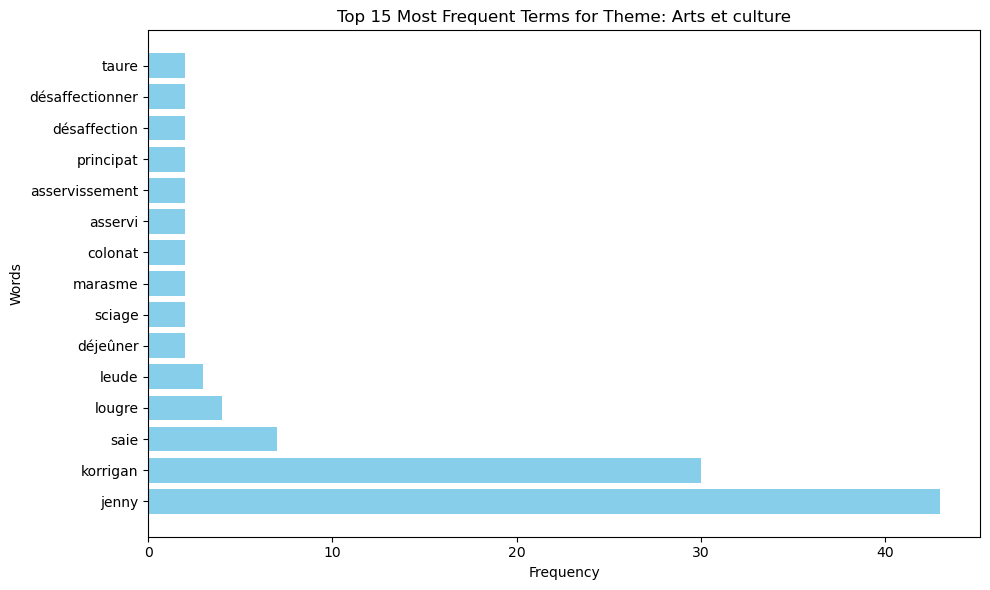

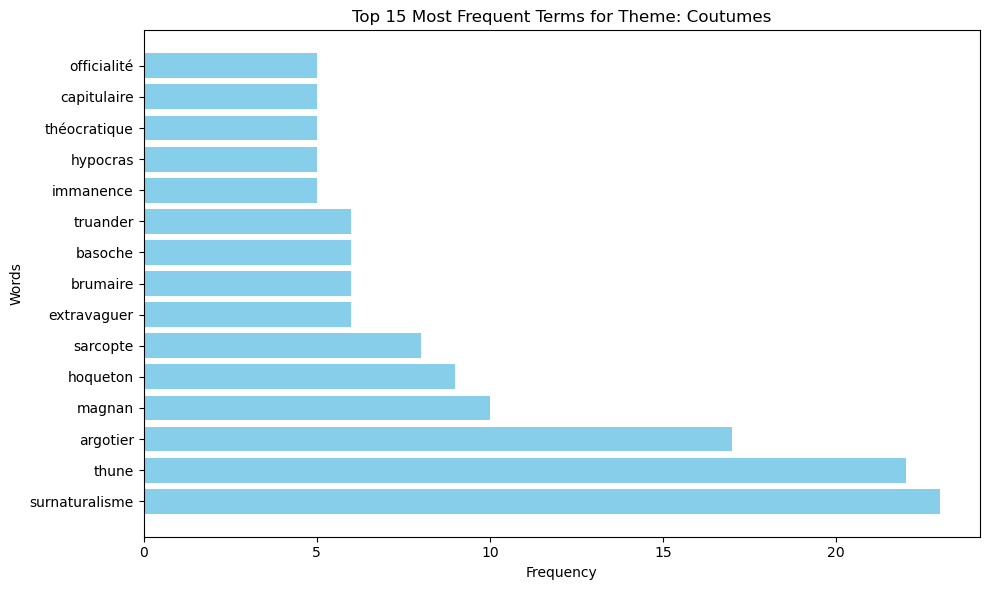

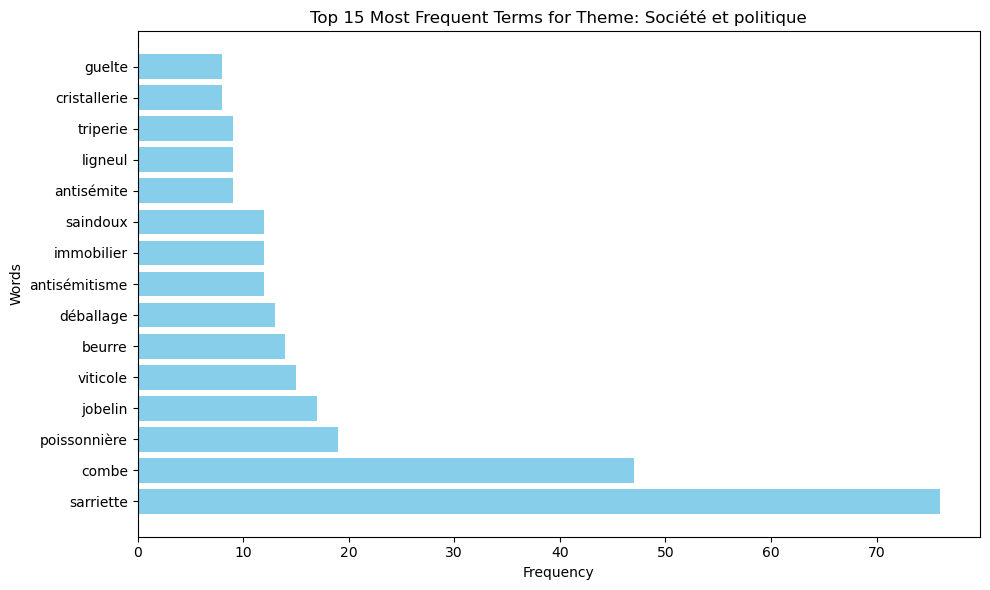

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

theme_word_freq = defaultdict(lambda: defaultdict(int))

exclude_types = ["epsilon", "ponctw", "poncts", "parento", "parentf", "np"]

total_word_freq = defaultdict(int)
word_theme_count = defaultdict(int)

for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes']
    book_id = idx
    book_df = data[data['Id'] == book_id]
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for word, freq, word_type in zip(words, frequencies, types):
        if word_type not in exclude_types:
            total_word_freq[word] += freq
            for theme in themes:
                word_theme_count[word] += 1

top_20_words = {word for word, freq in sorted(total_word_freq.items(), key=lambda x: x[1], reverse=True)[:20]}
exclude_words = {word for word, count in word_theme_count.items() if count > 3}

for idx, row in texts.iterrows():
    book_title = row['Title']
    themes = row['Themes']
    book_id = idx
    book_df = data[data['Id'] == book_id]
    words = book_df['Word']
    frequencies = book_df['Freq']
    types = book_df['Type']
    
    for theme in themes:
        for word, freq, word_type in zip(words, frequencies, types):
            if word_type not in exclude_types and word not in top_20_words and word not in exclude_words:
                freq = float(freq)
                theme_word_freq[theme.strip().lower()][word] += freq

themes_to_plot = ["Décadence", "Roman", "Coutumes","Société et politique", "Fiction historique","Arts et culture"]

for theme, word_freqs in theme_word_freq.items():
    if theme in [t.lower() for t in themes_to_plot]:
        sorted_words = sorted(word_freqs.items(), key=lambda x: x[1], reverse=True)[:15]
        words, freqs = zip(*sorted_words)
        plt.figure(figsize=(10, 6))
        plt.barh(words, freqs, color='skyblue')
        plt.title(f"Top 15 Most Frequent Terms for Theme: {theme.capitalize()}")
        plt.xlabel('Frequency')
        plt.ylabel('Words')
        plt.tight_layout()
        plt.show()


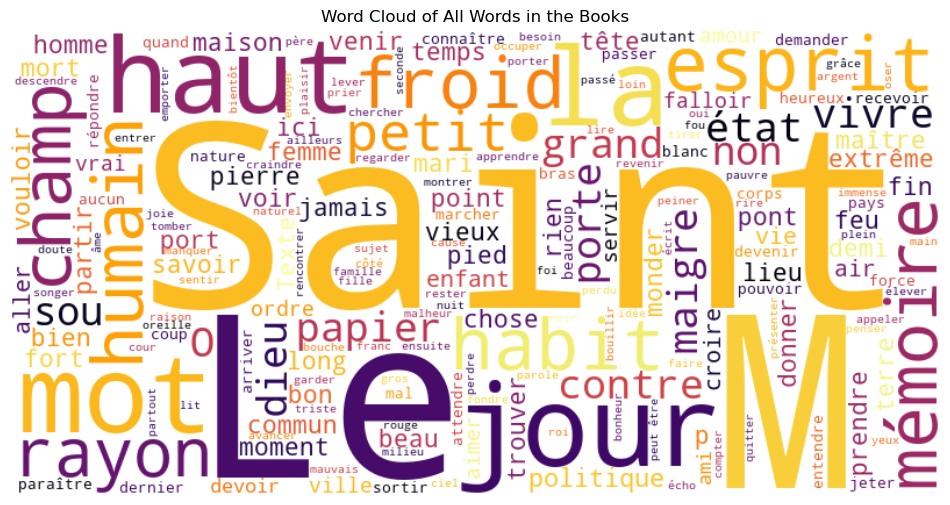

In [51]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

#Rassemble tous les mots dans data 
all_words = " ".join(data['Word'].astype(str))

#Création du nuage à partir des mots de data
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='inferno').generate(all_words)

#Taille graph
plt.figure(figsize=(12, 8))
#Dessin du nuage
plt.imshow(wordcloud, interpolation='bilinear')
#Retrait des axes
plt.axis('off')
#Titre
plt.title('Word Cloud of All Words in the Books')
#Affichage
plt.show()


) missing from font(s) DejaVu Sans.37: UserWarning: Glyph 13 (
  plt.tight_layout()
) missing from font(s) DejaVu Sans.ages/IPython/core/pylabtools.py:170: UserWarning: Glyph 13 (
  fig.canvas.print_figure(bytes_io, **kw)


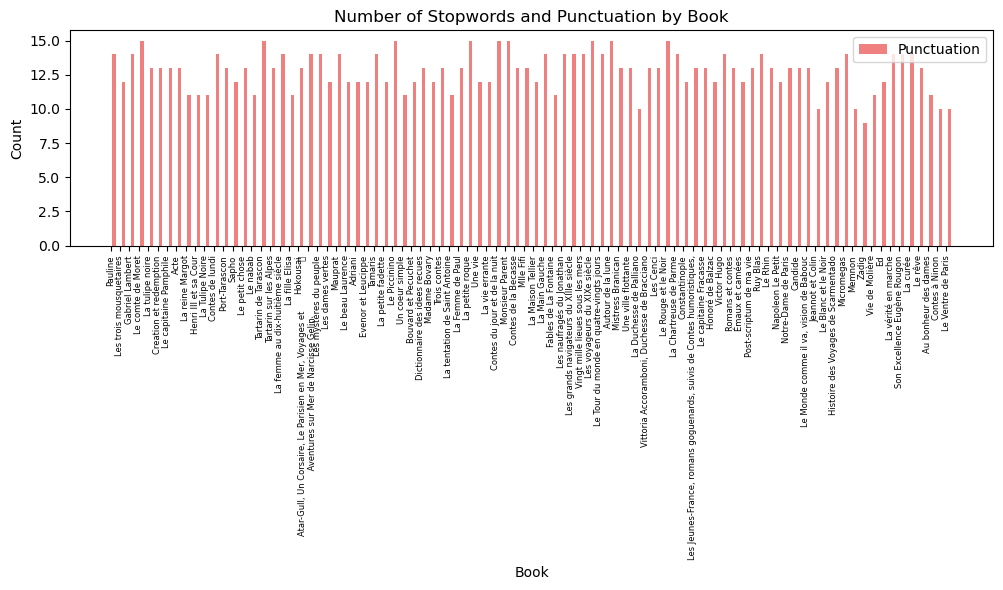

In [87]:
#pb car 47 vide probablement
import spacy
combined_df = pd.concat(l_data, ignore_index=True)

nlp = spacy.load("fr_core_news_sm")  #modèle français
stop_words_fr = nlp.Defaults.stop_words #liste de stopwords fr

# Step 2: Define a function to count stopwords and punctuation
def count_stopwords_punctuation(df, punctuation_types):
    punctuation_count = df[df['Type'].isin(punctuation_types)].shape[0]
    return punctuation_count

# Step 3: Count stopwords and punctuation for each dataframe (book)
punctuation_count = []
books = d_titles.values()

for df in l_data:
    punctuation_count_value = count_stopwords_punctuation(df, ["epsilon","ponctw","poncts","parento","parentf"])
    punctuation_count.append(punctuation_count_value)

# Step 4: Plot the results

# Bar plot for stopwords and punctuation counts
x = range(len(l_data))
width = 0.35  # The width of the bars

plt.figure(figsize=(10, 6))
plt.bar([p + width for p in x], punctuation_count, width, label='Punctuation', color='lightcoral')

# Customizing the plot
plt.title('Number of Stopwords and Punctuation by Book')
plt.xlabel('Book')
plt.ylabel('Count')
plt.xticks(ticks=range(len(books)), labels=books,rotation=90,fontsize=6)  # Position x-ticks at the center of bars
plt.legend()

plt.tight_layout()

# Show the plot
plt.show()


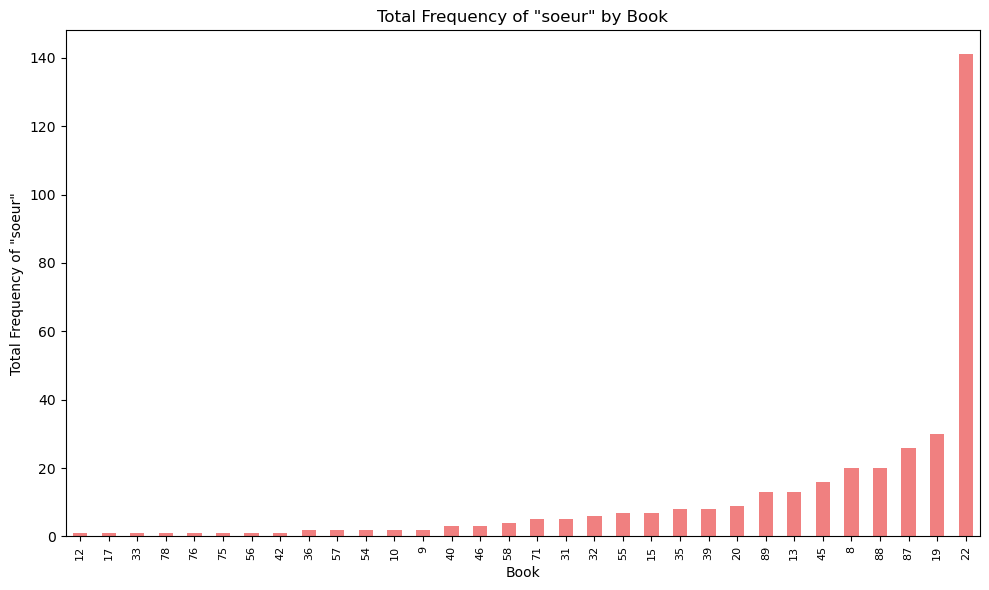

In [124]:
combined_df = pd.concat(l_data, ignore_index=True)

# Step 2: Filter the combined dataframe to only include the word "beautiful"
word_of_interest = "soeur"
word_df = combined_df[combined_df['Word'] == word_of_interest]

# Step 3: Sum the frequency of the word for each book
frequency_by_book = word_df.groupby('Id')['Count'].sum()

# Step 4: Plot the results
plt.figure(figsize=(10, 6))
frequency_by_book.sort_values().plot(kind='bar', color='lightcoral')

# Customizing the plot
plt.title(f'Total Frequency of "{word_of_interest}" by Book')
plt.xlabel('Book')
plt.ylabel(f'Total Frequency of "{word_of_interest}"')
plt.xticks(rotation=90, ha='center',fontsize=8)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()
